In [2]:
import sys
import os
sys.path.append(os.path.abspath(".."))

# Theoretical foundation
The reason for an increased degradation of classification performance in imbalanced noisy datasets is commonly attributed to the fact that the number of clean minority instances is even further reduced which makes deriving a proper decision function even harder [frenay] [knowledge_discov] [rater_model].
This would mean removing clean minority instances reduces classification performance.
The negative impact of overcleansing is reported as decreased classification performance, because such methods select to many minority instances into the false positives, which decreases classification performance relative to a method that does not overcleanse 

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [6]:
def train_evaluate_classifier(x_train, y_train, x_test, y_test, clf):

    assert 'label' not in x_train.columns 
    assert 'noisy_label' not in x_train.columns 

    assert 'label' not in x_test.columns 
    assert 'noisy_label' not in x_test.columns 

    clf.fit(x_train, y_train)

    y_true = y_test
    y_pred = clf.predict(x_test)

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)

    return f1

In [9]:
import pandas as pd

base_estimator = DecisionTreeClassifier(max_depth=1)

adaboost_clf = AdaBoostClassifier(estimator=base_estimator)

data = pd.read_csv('../../datasets/music/music_most_values_rf_corrupted.csv')

In [8]:
from sklearn.model_selection import train_test_split

X = data.drop(["label", "noisy_label"], axis=1)
y = data["label"]
y_noisy = data["noisy_label"]

original_x_train, original_x_test, original_y_train, original_y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

original_noisy_x_train, original_noisy_x_test, original_noisy_y_train, original_noisy_y_test = train_test_split(
    X, y_noisy, test_size=0.2, random_state=42
)

print(train_evaluate_classifier(original_x_train, original_y_train, original_x_test, original_y_test, clf=adaboost_clf))
print(train_evaluate_classifier(original_noisy_x_train, original_noisy_y_train, original_noisy_x_test, original_noisy_y_test, clf=adaboost_clf))


0.8970530451866404
0.7533916189327706


In [9]:
import numpy as np

def calculate_classifier_performance(train_df):
    minority_instances = train_df[train_df["label"] == 1]
    majority_instances = train_df[train_df["label"] == 0]

    sampled_minority = minority_instances.sample(frac=frac, random_state=42)

    sampled_train_df = pd.concat([sampled_minority, majority_instances])
    X_train = sampled_train_df.drop("label", axis=1)
    y_train = sampled_train_df["label"]
    return train_evaluate_classifier(X_train, y_train, original_x_test, original_y_test, clf=adaboost_clf)

clean_train_df = pd.concat([original_x_train, original_y_train], axis=1)
noisy_train_df = pd.concat([original_noisy_x_train, original_noisy_y_train], axis=1).rename(columns={"noisy_label": "label"})

fractions = np.arange(0.05, 1.05, 0.05)
results_clean = []
results_noisy = []

for frac in fractions: 
    result_clean = calculate_classifier_performance(clean_train_df)
    result_noisy = calculate_classifier_performance(noisy_train_df)
    results_clean.append((frac, result_clean))
    results_noisy.append((frac, result_noisy))



In [12]:
from constants.visualization_defaults import FIG_SIZE, FONT_SIZE_PARAMS
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.size': 18,
    'axes.titlesize': 20,   
    'axes.labelsize': 18,   
    'xtick.labelsize': 16,  
    'ytick.labelsize': 16,  
    'legend.fontsize': 18   
}) 

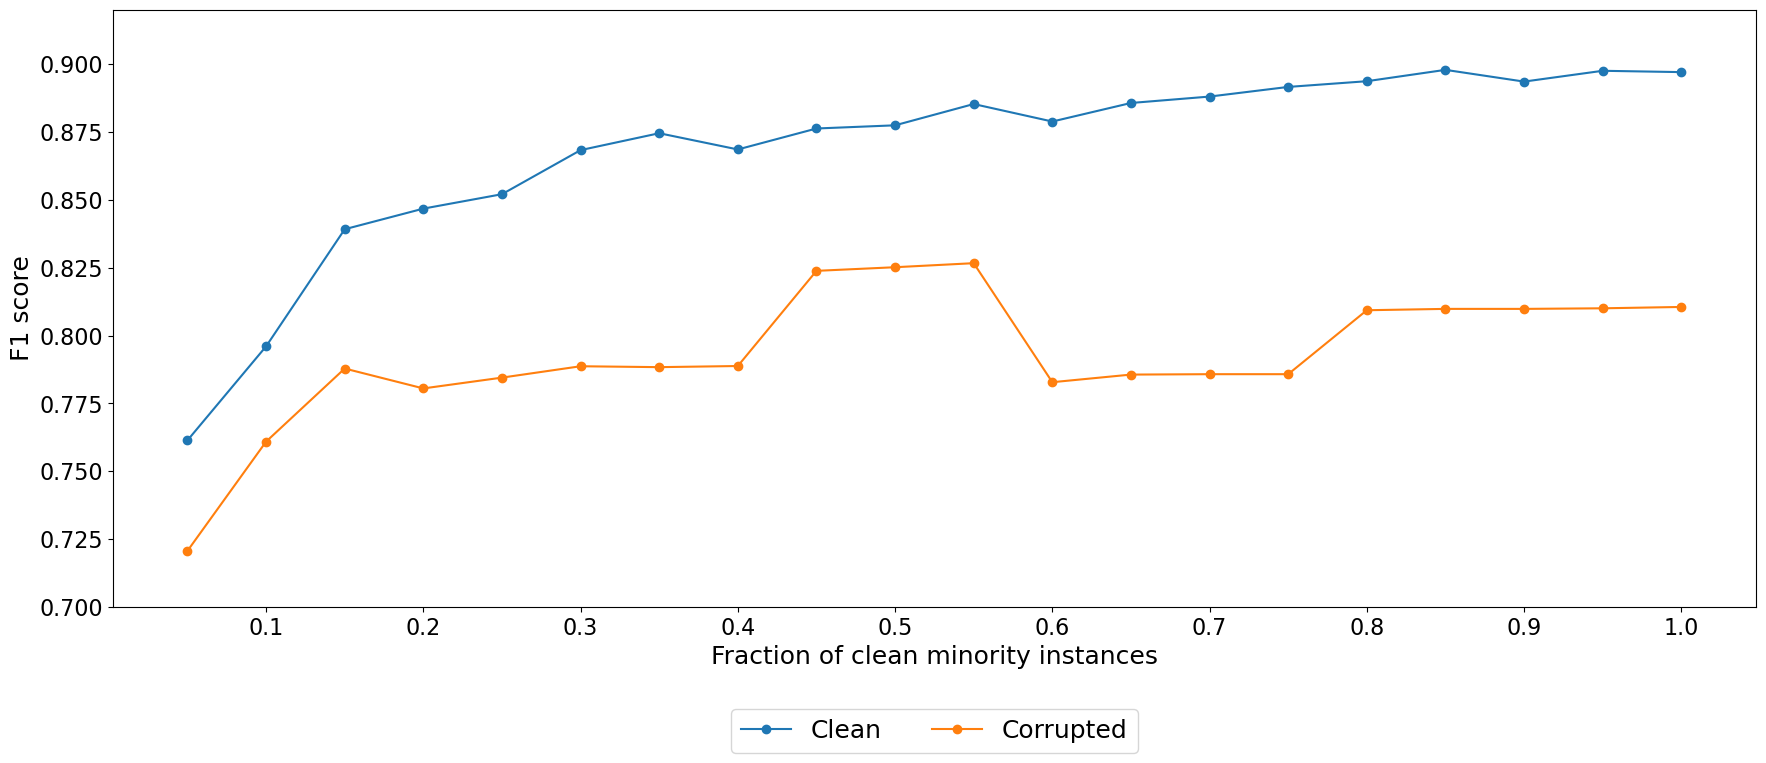

In [15]:
import matplotlib.pyplot as plt

x = [value[0] for value in results_clean]
y_clean = [value[1] for value in results_clean]
y_noisy = [value[1] for value in results_noisy]

plt.figure(figsize=(FIG_SIZE))
plt.plot(x, y_clean, label="Clean", marker='o')
plt.plot(x, y_noisy, label="Corrupted", marker='o')
plt.xticks(np.arange(0.1, 1.1, 0.1))
plt.ylim(0.7, 0.92)
plt.xlabel("Fraction of clean minority instances")
plt.ylabel("F1 score")
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,
)
plt.tight_layout()
plt.show()

# Interpretation

Since this effect of removing too many minority instances leads at some point to a drastic reduction in classification performance is visible on clean data as well as on noisy data, it can be expected that this effect is similarly visible on data that was cleaned by a denoising method.
This would imply that not overcleansing in general leads to significant degradations of downstream classifier performance but rather that when the combination of low precision and especially high overcleansing, removes so many instances that the minority class gets so much reduced that learning a decision boundary is no longer possible.
This effect may also be eleviated by the specific noise model and noise rate.
Intuitively a higher noise rate reduces the number of clean minority instances in the first place before cleansing (and potentially overcleansing) has kicked in.
Even further if an assymetric noise model is selected which favors mislabeling minortiy instances (e.g. CCN with alpha = mislabeling majority and beta = mislabeling minority and alpha << beta) the number of minority instances is further decreased before cleansing.
This effect is demonstrated in the following visualization

These observations explain why the effect of overcleansing on downstream classifier performance is not as pronounced in the here evaluated RLN.
The noise rate is relatively small, the mislabeling probabilities are symmetric, precision is not too low and overcleansing on the other hand not as pronounced to reduce the number of minority instances so drastically that a significant decrease in classification performance is observable.


In [10]:
def get_precision_06_recall_08(corrupted_data):
    correctly_labeled = corrupted_data[corrupted_data["label"] == corrupted_data["noisy_label"]]
    mislabeled = corrupted_data[corrupted_data["label"] != corrupted_data["noisy_label"]]

    number_tp = 10173
    number_fp = 6782 # precision = 0.6


    tp = mislabeled[:number_tp]
    fn = mislabeled[number_tp+1:]

    overcleansing_target = 20

    fp_no_overcleansing = correctly_labeled.sample(n=number_fp, random_state=42)

    correctly_labeled_matches = correctly_labeled[correctly_labeled["label"] == 1]
    correctly_labeled_non_matches = correctly_labeled[correctly_labeled["label"] == 0]

    clean_matches_in_fp = round(((overcleansing_target * len(correctly_labeled_matches) * number_fp) / len(correctly_labeled_non_matches)) / (1 + ((overcleansing_target * len(correctly_labeled_matches)) / len(correctly_labeled_non_matches))))
    clean_non_matches_in_fp = number_fp - clean_matches_in_fp

    fp_overcleansing = pd.concat([correctly_labeled_matches[:clean_matches_in_fp], correctly_labeled_non_matches[:clean_non_matches_in_fp]], axis=0)

    overcleansing_measure = ((clean_matches_in_fp) / len(correctly_labeled_matches)) / ((clean_non_matches_in_fp) / len(correctly_labeled_non_matches))

    print('overcleansing', overcleansing_measure)

    cleaned_iln_precision_06_overcleansing_1 = corrupted_data.drop(list(tp.index) + list(fp_no_overcleansing.index))
    cleaned_iln_precision_06_overcleansing_20 = corrupted_data.drop(list(tp.index) + list(fp_overcleansing.index))

    return cleaned_iln_precision_06_overcleansing_1, cleaned_iln_precision_06_overcleansing_20

def get_precision_01(corrupted_data):
    correctly_labeled = corrupted_data[corrupted_data["label"] == corrupted_data["noisy_label"]]
    mislabeled = corrupted_data[corrupted_data["label"] != corrupted_data["noisy_label"]]

    tp = mislabeled[:3688]
    fn = mislabeled[3689:]

    fp_no_overcleansing = correctly_labeled.sample(n=33192, random_state=42)

    correctly_labeled_matches = correctly_labeled[correctly_labeled["label"] == 1]
    correctly_labeled_non_matches = correctly_labeled[correctly_labeled["label"] == 0]

    fp_overcleansing = pd.concat([correctly_labeled_matches[:16148], correctly_labeled_non_matches[:17044]], axis=0)

    cleaned_iln_precision_01_overcleansing_1 = corrupted_data.drop(list(tp.index) + list(fp_no_overcleansing.index))
    cleaned_iln_precision_01_overcleansing_20 = corrupted_data.drop(list(tp.index) + list(fp_overcleansing.index))

    return cleaned_iln_precision_01_overcleansing_1, cleaned_iln_precision_01_overcleansing_20

In [11]:
import pandas as pd
from util.create_artificial_dataset import corrupt_ccn, corrupt_sln, corrupt_iln
from sklearn.svm import LinearSVC


music = pd.read_csv("../../datasets/music/preprocessed_music_most_values.csv")

features = music.drop("label", axis=1)
label = music["label"]

x_train, x_test, y_train, y_test = train_test_split(
    features, label, test_size=0.2, random_state=42
)

train_df = pd.concat([x_train, y_train], axis=1).reset_index(drop=True)

iln_corrupted = corrupt_iln(train_df, RandomForestClassifier(), "music_most_values")
ccn_corrupted = corrupt_ccn(train_df, 0.01, 0.3)

In [12]:
print(f'ILN noise rate {((len(iln_corrupted[iln_corrupted["label"] != iln_corrupted["noisy_label"]]) / len(iln_corrupted)) * 100):.3f} %')
print(f'ccn noise rate {((len(ccn_corrupted[ccn_corrupted["label"] != ccn_corrupted["noisy_label"]]) / len(ccn_corrupted)) * 100):.3f} %')

ILN noise rate 2.099 %
ccn noise rate 2.317 %


In [13]:
cleaned_iln_precision_06_overcleansing_1, cleaned_iln_precision_06_overcleansing_20 = get_precision_06_recall_08(iln_corrupted)
cleaned_iln_precision_01_overcleansing_1, cleaned_iln_precision_01_overcleansing_20 = get_precision_01(iln_corrupted)

overcleansing 19.995645771629505


In [14]:
iln_cleaned_precision_06_overcleansing_1 = train_evaluate_classifier(cleaned_iln_precision_06_overcleansing_1.drop(["label", "mislabeling_probability", "noisy_label"], axis=1), cleaned_iln_precision_06_overcleansing_1["noisy_label"], x_test, y_test, clf=adaboost_clf)
iln_cleaned_precision_06_overcleansing_20 = train_evaluate_classifier(cleaned_iln_precision_06_overcleansing_20.drop(["label", "mislabeling_probability", "noisy_label"], axis=1), cleaned_iln_precision_06_overcleansing_20["noisy_label"], x_test, y_test, clf=adaboost_clf)
iln_cleaned_precision_01_overcleansing_20 = train_evaluate_classifier(cleaned_iln_precision_01_overcleansing_20.drop(["label", "mislabeling_probability", "noisy_label"], axis=1), cleaned_iln_precision_01_overcleansing_20["noisy_label"], x_test, y_test, clf=adaboost_clf)

iln_corrupted_features = iln_corrupted.drop(["label", "noisy_label", "mislabeling_probability"], axis=1)
iln_corrupted_labels = iln_corrupted["noisy_label"]

iln_corrupted_performance = train_evaluate_classifier(iln_corrupted_features, iln_corrupted_labels, x_test, y_test, clf=adaboost_clf)

In [15]:
print(iln_corrupted_performance)
print(iln_cleaned_precision_06_overcleansing_1)
print(iln_cleaned_precision_06_overcleansing_20)
print(iln_cleaned_precision_01_overcleansing_20)

0.8087411955932816
0.8930793157076206
0.8687943262411347
0.677853935239896


In [16]:
from constants.visualization_defaults import FIG_SIZE, FONT_SIZE_PARAMS
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.size': 18,
    'axes.titlesize': 20,   
    'axes.labelsize': 18,   
    'xtick.labelsize': 16,  
    'ytick.labelsize': 16,  
    'legend.fontsize': 18   
}) 

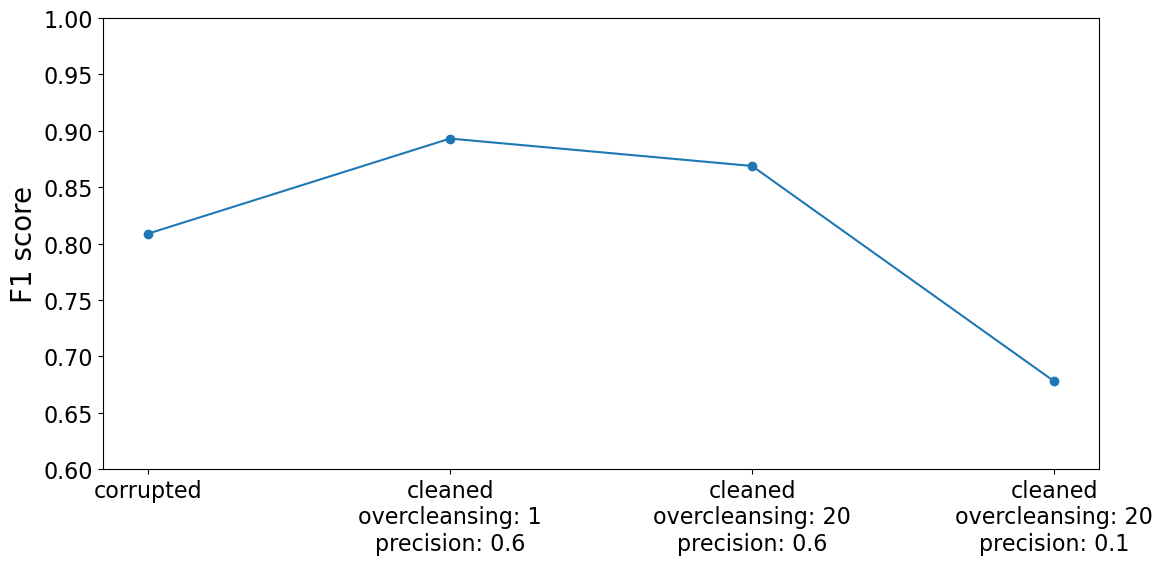

In [18]:
from constants.visualization_defaults import FIG_SIZE, FONT_SIZE_PARAMS
import matplotlib.pyplot as plt

x_labels = [ "corrupted", "cleaned\novercleansing: 1\nprecision: 0.6", "cleaned\novercleansing: 20\nprecision: 0.6", "cleaned\novercleansing: 20\nprecision: 0.1", ]

y_values = [
    iln_corrupted_performance,
    iln_cleaned_precision_06_overcleansing_1,
    iln_cleaned_precision_06_overcleansing_20,
    iln_cleaned_precision_01_overcleansing_20,
]

x_positions = range(len(y_values))



plt.rcParams.update({
    'font.size': 18,
    'axes.titlesize': 20,   
    'axes.labelsize': 20,   
    'xtick.labelsize': 16,  
    'ytick.labelsize': 16,  
    'legend.fontsize': 18   
}) 

plt.figure(figsize=(12,6))
plt.plot(x_positions, y_values, marker='o')
plt.ylim(0.6, 1)
plt.xticks(x_positions, x_labels)
plt.ylabel("F1 score")
plt.tight_layout()
plt.show()